In [3]:
#Imports 
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
from datasets import load_dataset
from transformers import AutoTokenizer
import random

/Users/ammarnagri/miniconda3/envs/emotion_detection/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
#Helper function to generate confusion matrix
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.savefig("confusion_matrix.png")

In [5]:
dataset = load_dataset("emotion")

#Separate the data into train,test and validation sets
train_data = dataset["train"]
test_data = dataset["test"]
validation_data = dataset["validation"]

In [6]:
#Generate class names
classes = train_data.features["label"].names
classes

['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

In [7]:
def get_tweets(data):
    """
    Separates the data into tweets and their labels of emotion

    Input:
    data : datasets.arrow_dataset.Dataset

    Output:
    tweets : list
    labels : list
    """
    tweets = [x["text"] for x in data]
    label = [x["label"] for x in data]
    return tweets,label

In [8]:
#Extracting training tweets and labels
train_tweets , train_labels = get_tweets(train_data)
train_tweets[0],classes[train_labels[0]]

('i didnt feel humiliated', 'sadness')

In [9]:
#Encode the tweets to tensors for the model
maxlen = 100
tokeniser = AutoTokenizer.from_pretrained("bert-base-uncased")
training_encodings = tokeniser(
    train_tweets,
    truncation=True,
    padding="max_length",
    max_length=maxlen,
    return_tensors="pt"
)

# Convert tensor to list for easier viewing
print(training_encodings['input_ids'][0].tolist())  # first tweet tokens as integers


/Users/ammarnagri/miniconda3/envs/emotion_detection/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Text(0.5, 1.0, 'Frequency of number of words in sentences')

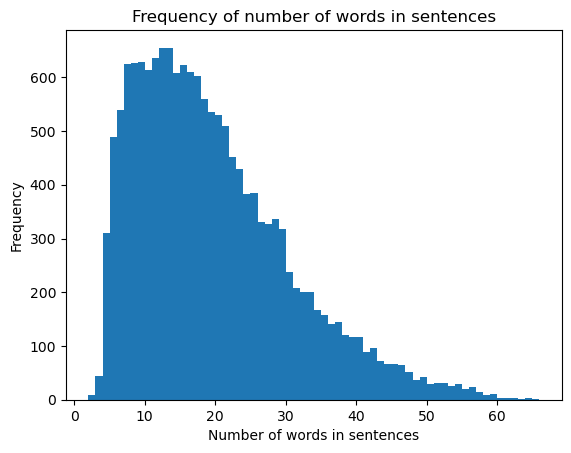

In [10]:
#Histogram of the frequency of words
lengths = [len(l.split(" ")) for l in train_tweets]

plt.hist(lengths, bins=len(set(lengths)))
plt.ylabel("Frequency")
plt.xlabel("Number of words in sentences")
plt.title("Frequency of number of words in sentences")

In [11]:
#Helper functions to convert classes to index and vice versa
index_set = set(train_labels)
index_set,classes

class_to_index = dict((c,i) for i,c in enumerate(classes))
index_to_class = dict((v, k) for k, v in class_to_index.items())

class_to_id = lambda labels : np.array([class_to_index.get(x) for x in labels])

In [12]:
class BiLSTMClassifier(nn.Module):
    def __init__(self, vocab_size= tokeniser.vocab_size, embed_dim=16, hidden_dim=20, num_classes=6):
        """
        Bidirectional LSTM classifier for text classification.

        Args:
            vocab_size (int): Size of the vocabulary.
            embed_dim (int): Dimension of the embedding vectors.
            hidden_dim (int): Number of hidden units in each LSTM direction.
            num_classes (int): Number of output classes.
        """
        super(BiLSTMClassifier, self).__init__()
        
        # Embedding layer with padding index set to 0
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        
        # First BiLSTM layer (outputs full sequence)
        self.lstm1 = nn.LSTM(embed_dim, hidden_dim, batch_first=True, bidirectional=True)
        
        # Second BiLSTM layer (produces hidden states for classification)
        self.lstm2 = nn.LSTM(hidden_dim * 2, hidden_dim, batch_first=True, bidirectional=True)
        
        # Fully connected classification head
        self.fc = nn.Linear(hidden_dim * 2, num_classes)
        
    def forward(self, x):
        """
        Forward pass through the model.

        Args:
            x (Tensor): Input tensor of shape [batch_size, seq_len].

        Returns:
            Tensor: Logits of shape [batch_size, num_classes].
        """
        # Embed input token indices
        x = self.embedding(x)   # [batch_size, seq_len, embed_dim]
        
        # Pass through first BiLSTM
        x, _ = self.lstm1(x)    # [batch_size, seq_len, hidden_dim*2]
        
        # Pass through second BiLSTM
        x, (h, _) = self.lstm2(x)
        
        # Concatenate last forward and backward hidden states
        h_final = torch.cat((h[-2], h[-1]), dim=1)  # [batch_size, hidden_dim*2]
        
        # Classification output
        out = self.fc(h_final)  # [batch_size, num_classes]
        return out


model = BiLSTMClassifier()
print(model)

BiLSTMClassifier(
  (embedding): Embedding(30522, 16, padding_idx=0)
  (lstm1): LSTM(16, 20, batch_first=True, bidirectional=True)
  (lstm2): LSTM(40, 20, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=40, out_features=6, bias=True)
)


In [13]:
#Extracting training tweets and labels
validation_tweets , validation_labels = get_tweets(validation_data)
#Encode the tweets to tensors for the model
tokeniser = AutoTokenizer.from_pretrained("bert-base-uncased")
validation_encodings = tokeniser(
    validation_tweets,
    truncation=True,
    padding="max_length",
    max_length=maxlen,
    return_tensors="pt"
)

validation_tweets[0] , validation_labels[0] , index_to_class.get(validation_labels[0])

('im feeling quite sad and sorry for myself but ill snap out of it soon',
 0,
 'sadness')

In [14]:
#Transform the data and create a dataloader
train_data = TensorDataset(
    torch.tensor(training_encodings["input_ids"], dtype=torch.long),
    torch.tensor(train_labels, dtype=torch.long)
)
val_data = TensorDataset(
    torch.tensor(validation_encodings["input_ids"], dtype=torch.long),
    torch.tensor(validation_labels, dtype=torch.long)
)

# DataLoaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)


/var/folders/f4/6nksv7x524b83jql0f8wvtkh0000gn/T/ipykernel_41841/1568152633.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(training_encodings["input_ids"], dtype=torch.long),
/var/folders/f4/6nksv7x524b83jql0f8wvtkh0000gn/T/ipykernel_41841/1568152633.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(validation_encodings["input_ids"], dtype=torch.long),


In [15]:
#Set device
if torch.backends.mps.is_available():
    device = torch.device("mps")    # Apple Silicon GPU
else:
    device = torch.device("cpu")    # Fallback

model = BiLSTMClassifier().to(device)

#Set loss and optimiser
criterion = nn.CrossEntropyLoss()
optimiser = optim.Adam(model.parameters(), lr=0.001)


In [16]:
epochs = 20
patience = 3   # stop training if validation accuracy does not improve for 'patience' epochs
best_val_acc = 0.0
counter = 0

train_history, val_history = [], []

for epoch in range(epochs):
    # Training phase
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)

        optimiser.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, y)
        loss.backward()
        optimiser.step()

        # Track loss and accuracy
        running_loss += loss.item()
        _, preds = torch.max(outputs, dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)

    train_acc = correct / total
    train_history.append(train_acc)

    # Validation phase
    model.eval()
    val_correct, val_total = 0, 0
    
    with torch.no_grad():
        for X, y in val_loader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            _, preds = torch.max(outputs, dim=1)
            val_correct += (preds == y).sum().item()
            val_total += y.size(0)

    val_acc = val_correct / val_total
    val_history.append(val_acc)

    print(
        f"Epoch {epoch+1}/{epochs}, "
        f"Loss: {running_loss:.3f}, "
        f"Train Acc: {train_acc:.3f}, "
        f"Val Acc: {val_acc:.3f}"
    )


    # Early stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break


Epoch 1/20, Loss: 790.566, Train Acc: 0.338, Val Acc: 0.390
Epoch 2/20, Loss: 710.000, Train Acc: 0.463, Val Acc: 0.479
Epoch 3/20, Loss: 571.536, Train Acc: 0.586, Val Acc: 0.602
Epoch 4/20, Loss: 465.843, Train Acc: 0.661, Val Acc: 0.651
Epoch 5/20, Loss: 393.302, Train Acc: 0.712, Val Acc: 0.672
Epoch 6/20, Loss: 328.342, Train Acc: 0.766, Val Acc: 0.740
Epoch 7/20, Loss: 272.712, Train Acc: 0.812, Val Acc: 0.767
Epoch 8/20, Loss: 229.498, Train Acc: 0.845, Val Acc: 0.784
Epoch 9/20, Loss: 198.076, Train Acc: 0.866, Val Acc: 0.797
Epoch 10/20, Loss: 193.678, Train Acc: 0.868, Val Acc: 0.806
Epoch 11/20, Loss: 163.585, Train Acc: 0.887, Val Acc: 0.812
Epoch 12/20, Loss: 145.293, Train Acc: 0.900, Val Acc: 0.823
Epoch 13/20, Loss: 124.698, Train Acc: 0.910, Val Acc: 0.833
Epoch 14/20, Loss: 116.544, Train Acc: 0.919, Val Acc: 0.835
Epoch 15/20, Loss: 102.642, Train Acc: 0.928, Val Acc: 0.845
Epoch 16/20, Loss: 95.591, Train Acc: 0.934, Val Acc: 0.851
Epoch 17/20, Loss: 81.702, Train A

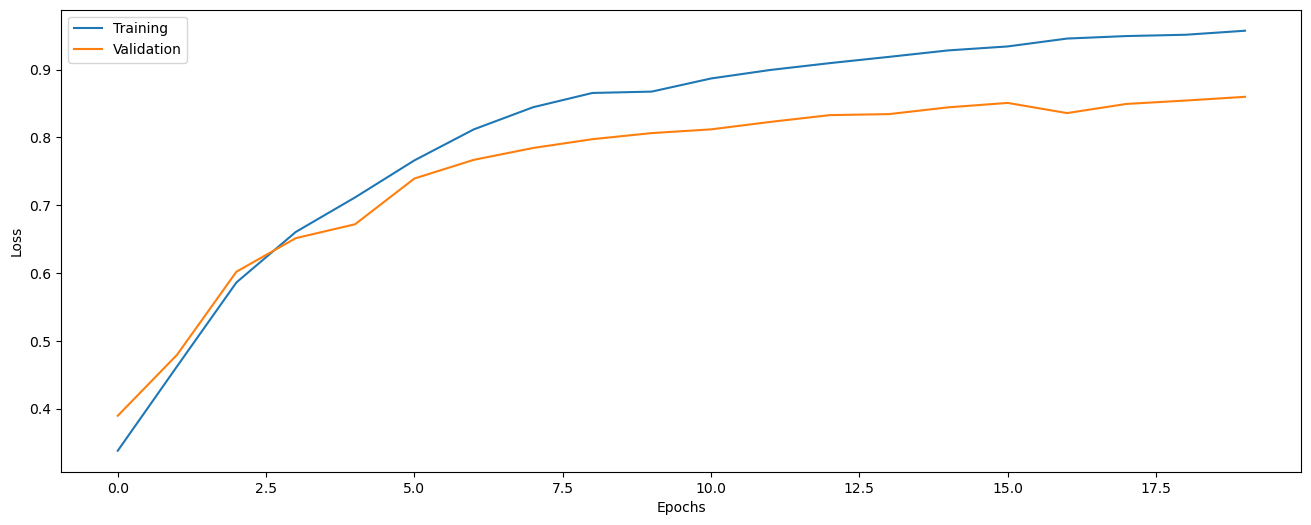

In [17]:
#Visualise the training and val loss
plt.figure(figsize=(16, 6))

plt.plot(range(0, epochs), train_history, label='Training')
plt.plot(range(0, epochs), val_history, label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [18]:
#Extracting training tweets and labels
test_tweets , test_labels = get_tweets(test_data)
#Encode the tweets to tensors for the model
len(test_tweets)
testing_encodings = tokeniser(
    test_tweets,
    truncation=True,
    padding="max_length",
    max_length=maxlen,
    return_tensors="pt"
)

In [19]:
#Transform the testing data and create a dataloader
test_data = TensorDataset(
    torch.tensor(testing_encodings["input_ids"], dtype=torch.long),
    torch.tensor(test_labels, dtype=torch.long)
)

test_loader = DataLoader(test_data, batch_size=32, shuffle=True)

/var/folders/f4/6nksv7x524b83jql0f8wvtkh0000gn/T/ipykernel_41841/256977002.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(testing_encodings["input_ids"], dtype=torch.long),


In [20]:
def evaluate(model, test_loader, criterion, device: str = "cpu"):
    """
    Evaluate a trained model on a test dataset.

    Args:
        model (nn.Module): Trained PyTorch model to be evaluated.
        test_loader (DataLoader): DataLoader for the test dataset.
        criterion (nn.Module): Loss function.
        device (str): Device to run evaluation on ("cpu" or "cuda").

    Returns:
        tuple[float, float]: Average loss and accuracy on the test set.
    """
    model.eval()
    total_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():  # disable gradient tracking for efficiency
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Accumulate weighted loss
            total_loss += loss.item() * labels.size(0)

            # Compute predictions
            _, predicted = torch.max(outputs, dim=1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_loss = total_loss / total
    accuracy = correct / total
    return avg_loss, accuracy


# Example usage
test_loss, test_acc = evaluate(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.3f}, Test Acc: {test_acc:.3f}")


Test Loss: 0.544, Test Acc: 0.850


In [21]:
#Visualisation of the models ability to predict the emotion
index = random.randint(0, len(testing_encodings["input_ids"]) - 1)

input_tensor = torch.tensor(testing_encodings["input_ids"][index], dtype=torch.long).unsqueeze(0).to(device)  

model.eval()
with torch.no_grad():
    output = model(input_tensor)
    predicted_class = torch.argmax(output, dim=1).item()

# show results
print(f"Sentence: {test_tweets[index]}")
print(f"True label: {index_to_class.get(test_labels[index])}")
print(f"Predicted emotion: {index_to_class.get(predicted_class)}")


Sentence: i wonder how it feels to be loved by someone you love
True label: love
Predicted emotion: love


/var/folders/f4/6nksv7x524b83jql0f8wvtkh0000gn/T/ipykernel_41841/2065533766.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_tensor = torch.tensor(testing_encodings["input_ids"][index], dtype=torch.long).unsqueeze(0).to(device)


In [22]:
#Produce the predictions for the entire testing dataset
model.eval()
all_preds = []

with torch.no_grad():  
        outputs = model(testing_encodings["input_ids"].to(device))
        probs = torch.softmax(outputs, dim=1)  
        preds = torch.argmax(probs, dim=1)     

        all_preds.extend(preds.cpu().numpy())
y_pred = np.array(all_preds)

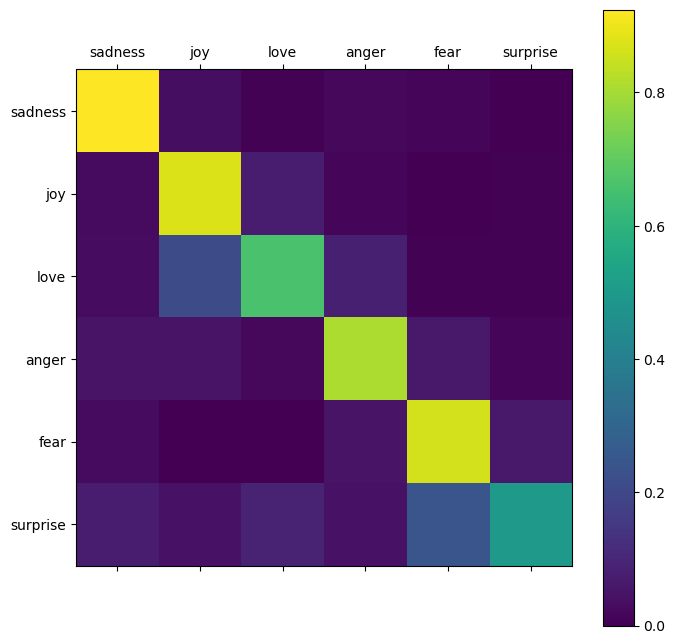

In [23]:
#Generate confusion matrix
show_confusion_matrix(classes= (classes),y_true=test_labels,y_pred=y_pred.tolist())